<h1><center>LSTM Language Detection</center></h1>
<h3><center>CSE 6240 - Websearch and Text Mining</center></h3>

<h7><center>Adam Lieberman, Garrett Mallory, Ravish Chawla</center></h7>
<h7><center>April 25, 2017</center></h7>

<h4>Introduction:</h4>
<p> In this project, we will be classifiying English and French text. We'll use a LSTM model to determine the probability of a text being either English or French and use a statistical method to determine the class of the text. We've included all the code here as well as some performance metrics at the end.</p>

<h4> Imports & helper functions </h4>
<p>Below are the modules used in this notebook:</p>

In [1]:
from __future__ import print_function;
import sys;
import random;
from random import randint

import numpy as np;

from keras.models import Sequential;
from keras.layers import Dense, Activation;
from keras.layers import LSTM;
from keras.optimizers import RMSprop;
from keras.utils.data_utils import get_file;
from keras.models import load_model;

from sklearn.cross_validation import train_test_split;
from sklearn.metrics import *;
from sklearn.externals import joblib;

import matplotlib.pyplot as plt;
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, Callback

import subprocess;
import h5py;

Using TensorFlow backend.
/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h4>Load Data:</h4>
<p>Next, we will load in the English and French text, and lowercase the alphabet.</p>

In [2]:
english_text = open('data/eng.txt').read().lower()
french_text = open('data/frn.txt').read().lower()

print('English corpus length:', len(english_text))
print('French corpus length:', len(french_text))

English corpus length: 10746
French corpus length: 12009


<h4>Character Set and Dictionary:</h4>
<p>We will obtain the Charachter map for both English and French by iterating over each single-letter string and adding it to a dictionary. We create both a forward-facing dictionary and an inverse-dictionary. The purpose of this dictionary is to map the features to the feature indices in our design matrix.</p>

In [3]:
english_chars = sorted(list(set(english_text)))
french_chars = sorted(list(set(french_text)))

english_char_map = dict((c, i) for i, c in enumerate(english_chars))
french_char_map = dict((c, i) for i, c in enumerate(french_chars))

english_char_map_inverse = dict((i, c) for i, c in enumerate(english_chars))
french_char_map_inverse = dict((i, c) for i, c in enumerate(french_chars))

<h4>Sentence Creation:</h4>
<p>In the next step, we will create sentences from both English and French text in a rolling window of 40 charchters. These will be our features. After this step is complete, we will obtain a [x, 40] matrices, where each row will have length alphabet-size.</p>

In [5]:
maxlen = 40
step = 3

english_sentences = []
english_next_chars = []
for i in range(0, len(english_text) - maxlen, step):
    english_sentences.append(english_text[i: i + maxlen])
    english_next_chars.append(english_text[i + maxlen])

french_sentences = []
french_next_chars = []
for i in range(0, len(french_text) - maxlen, step):
    french_sentences.append(french_text[i: i + maxlen])
    french_next_chars.append(french_text[i + maxlen])
    
print('nb English sequences:', len(english_sentences))
print('nb French sequences:', len(french_sentences))

nb English sequences: 3569
nb French sequences: 3990


<h4>Design Matrix Creation:</h4>
<p>Now we will vectorize the above matrices by creating a design matrix. This will result in a [x, 40, max-alphabet-length] matrices for both English and French.

In [6]:
print('Vectorization...')

char_len = max(len(english_chars), len(french_chars));

english_x = np.zeros((len(english_sentences), maxlen, char_len), dtype=np.bool)
english_y = np.zeros((len(english_sentences), char_len), dtype=np.bool)
for i, sentence in enumerate(english_sentences):
    for t, char in enumerate(sentence):
        english_x[i, t, english_char_map[char]] = 1
    english_y[i, english_char_map[english_next_chars[i]]] = 1
    
    
french_x = np.zeros((len(french_sentences), maxlen, char_len), dtype=np.bool)
french_y = np.zeros((len(french_sentences), char_len), dtype=np.bool)
for i, sentence in enumerate(french_sentences):
    for t, char in enumerate(sentence):
        french_x[i, t, french_char_map[char]] = 1
    french_y[i, french_char_map[french_next_chars[i]]] = 1

print("Finished!")

Vectorization...
Finished!


<h4>Train-test Split:</h4>
<p>We need to obtain a Train/Test split from our data now. This allows us to obtain a random 20% subset of data for testing and the remaining for training.</p>

In [7]:
english_train_x, english_test_x, english_train_y, english_test_y = train_test_split(english_x, english_y, test_size=0.2, random_state=1024);
french_train_x, french_test_x, french_train_y, french_test_y = train_test_split(french_x, french_y, test_size=0.2, random_state=1024);

To check our results so far, let's print the shapes of our Training and testing matrices. As the results below show, both languages have [x, 40, 43] values for training, even though French has 41 total alphabet charachters. We see this because we pad the smaller language with 2 extra columns of all 0s, in order to make sure that our neural network can train properly on the same input shape.

In [8]:
print('English Shapes');
print(english_train_x.shape);
print(english_train_y.shape);
print(english_test_x.shape);
print(english_test_y.shape);
print()
print('French Shapes');
print(french_train_x.shape);
print(french_train_y.shape);
print(french_test_x.shape);
print(french_test_y.shape);

English Shapes
(2855, 40, 43)
(2855, 43)
(714, 40, 43)
(714, 43)

French Shapes
(3192, 40, 43)
(3192, 43)
(798, 40, 43)
(798, 43)


<h4>Generate Testing Data:</h4>
<p>Having obtained the test split, we need to obtain a smaller sample of 100 strings of 5 length charachters each. We do this by using a Random number generator to select a random string each time, append it to our features array, along with the label associated with it.</p>

In [29]:
def random_generate(test_x, key):
    labels = []
    feats = []
    if key == "english": 
        labels = [1 for i in range(100)]
    elif key == 'french': 
        labels = [0 for i in range(100)]
    else:
        return feats, labels;
    
    for i in range(100): 
        r1 = randint(0, len(test_x) - 1)
        ind = test_x[r1]
        
        r2 = randint(0, len(ind) - 5)
        
        sub_string = ind[r2:r2+5]
        
        feats.append(sub_string)
        
    return feats,labels
    
english_sample, english_labels = random_generate(english_test_x, 'english');
french_sample, french_labels = random_generate(french_test_x, 'french');

test_data = np.array(english_sample + french_sample);
test_labels = np.array(english_labels + french_labels);

<h4>LSTM Model Creation:</h4>
<p>Now that we have obtained our data for training and testing, we will build a LSTM model. To do this, we will create a function that will build a Sequential LSTM model. The parameters for the model below have been tuned after testing multiple configurations with over 60 epochs each. We settled on using 256 Neurons on the LSTM layer, with a RMSProp optimizer using 0.01 Learning rate. We will show our results on how we obtained these values later.</p>

In [10]:
def build_model(chars):
    print('Build model...')
    model = Sequential()
    model.add(LSTM(256, input_shape=(None, char_len)))
    model.add(Dense(char_len))
    model.add(Activation('softmax'))
    
    optimizer = RMSprop(lr=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']);
    return model

To do a prediction on our data, we will use a log of probabilities over each charachter in a string. We will iterate over each charachter, obtain the vector associated with it along with the previous START charachters, and obtain the prediction score for it on the next charachter. Finally, we sum up the logs of these values and return it.

In [12]:
def predict_on_sample(model, test_val):
    start = np.zeros((1, 1, char_len), dtype=bool);
    start_prob = model.predict(start);

    next_vec = start.copy()[0][0];
    probs = [];

    probs.append(start_prob[0,np.argwhere(test_val[0])[0][0]]);

    for idx, vec in enumerate(test_val):
        next_vec = np.append(next_vec, vec).reshape(1, idx+2, char_len)
        next_prob = model.predict(next_vec);

        probs.append(next_prob[0, np.argwhere(test_val[idx])[0][0]]);
        
    return np.sum(np.log(probs));

Using the above function, we can predict the results on each test string. To do this, we pass in the string along with both the English model and the French model, obtain the probabilities, and compute the GLRT. The ratio gives us a vector of probability scores, in which we set all values >= 1 to 1, and otherwise 0. The ROC score is computed on these values.

In [58]:
def predict_results(english_model, french_model):
    english_preds = np.array([predict_on_sample(english_model, x) for x in test_data]);
    french_preds = np.array([predict_on_sample(french_model, x) for x in test_data]);
    ratio_probs = english_preds - french_preds;
        
    fpr, tpr, _ = roc_curve(test_labels, ratio_probs);
    roc_auc = auc(fpr, tpr);
    
    print(roc_auc);

    return roc, fpr, tpr;

In [62]:
def plot_roc_auc_curve(fpr, tpr, roc_auc, title): 
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + title)
    plt.legend(loc="lower right")
    plt.show()

<h4>Hyperparameter Tuning:</h4>
<p> In order to do hyperparameter search, we wrote a function called train_and_predict(). We cycle though a set range of epochs and evaluate the model quality as the iterations increase. We then take the best performing model.</p>

<p>Other hyperparameters tuned are the learning rate, decay rate, batch sizes used in training, and size of the LSTM layer. Some of these we tuned manually rather than create a automated function for it. Finally, we found that the best performance is given by epochs=8, learning rate=0.01, decay=0.0, layer_size=256.</p>

<p>Below we display graphs showing the loss vs. epochs and accuracy vs. epochs for learning rate 0.01 as a demonstration of our parameter selection process.</p>
<center><img src="http://i.imgur.com/7QhIXwl.jpg"></center>
<center><img src="http://i.imgur.com/XyPN1xj.jpg"></center>


In [43]:
def train_and_predict(total_epochs, step_size = 3, batch_size=2512):
    english_model = build_model(english_chars)
    french_model = build_model(french_chars);
    epochs_ran = 0;

    for i in range(0, total_epochs, step_size):
        history_english = english_model.fit(english_train_x, english_train_y,
                            batch_size=batch_size, epochs=step_size, shuffle=True);
        history_french = french_model.fit(french_train_x, french_train_y,
                            batch_size=batch_size, epochs=step_size, shuffle=True);

        
        epochs_ran = epochs_ran + step_size;
        
        roc = predict_results(english_model, french_model);
        
        if epochs_ran >= total_epochs:
            break;
            
    return [english_model, french_model, roc];

<h4>Building English LSTM Model</h4>
<p>We call our function and set 5 epochs with a step size of 5 and optimal batch size of 2512.</p>

In [44]:
models_1 = train_and_predict(5, 5, 2512)

Build model...
Build model...
Epoch 1/5
2855/2855 [==============================] - 3s - loss: 3.7206 - acc: 0.0221     
Epoch 2/5
2855/2855 [==============================] - 2s - loss: 5.3884 - acc: 0.1426     
Epoch 3/5
2855/2855 [==============================] - 2s - loss: 4.2558 - acc: 0.0676     
Epoch 4/5
2855/2855 [==============================] - 2s - loss: 3.5550 - acc: 0.1625     
Epoch 5/5
2855/2855 [==============================] - 2s - loss: 3.4811 - acc: 0.0550     
Epoch 1/5
3192/3192 [==============================] - 3s - loss: 3.8357 - acc: 0.0711     
Epoch 2/5
3192/3192 [==============================] - 2s - loss: 3.4972 - acc: 0.0655     
Epoch 3/5
3192/3192 [==============================] - 2s - loss: 4.1910 - acc: 0.1103     
Epoch 4/5
3192/3192 [==============================] - 2s - loss: 3.0199 - acc: 0.0840     
Epoch 5/5
3192/3192 [==============================] - 2s - loss: 2.9137 - acc: 0.1732     
0.7948


<h4>Building English LSTM Model</h4>
<p>After training on 5 epochs, we retrain on 12 epochs with a step size of 3 epochs for our predictions. We've done this to increase ROC and experiement with parameter tuning over our previous test.</p>

In [45]:
models_2 = train_and_predict(12, 3, 2512)

Build model...
Build model...
Epoch 1/3
2855/2855 [==============================] - 3s - loss: 3.8244 - acc: 0.0319     
Epoch 2/3
2855/2855 [==============================] - 2s - loss: 3.8091 - acc: 0.0501     
Epoch 3/3
2855/2855 [==============================] - 2s - loss: 4.0902 - acc: 0.0630     
Epoch 1/3
3192/3192 [==============================] - 4s - loss: 3.6929 - acc: 0.0592     
Epoch 2/3
3192/3192 [==============================] - 2s - loss: 4.6424 - acc: 0.1419     
Epoch 3/3
3192/3192 [==============================] - 2s - loss: 4.5772 - acc: 0.0617     
0.8456
Epoch 1/3
2855/2855 [==============================] - 2s - loss: 3.1018 - acc: 0.1625     
Epoch 2/3
2855/2855 [==============================] - 2s - loss: 3.0159 - acc: 0.1541     
Epoch 3/3
2855/2855 [==============================] - 2s - loss: 3.0308 - acc: 0.1625     
Epoch 1/3
3192/3192 [==============================] - 2s - loss: 3.7905 - acc: 0.1604     
Epoch 2/3
3192/3192 [======================

Because there was a lot of variability in the model performance, we decided to rerun these cells multiple times and save the best performing model. We use this top model though our ROC varies between 0.65 and 0.95. 

In [75]:
models_1[3][0].save('model_current_e.h5')
models_1[3][1].save('model_current_f.h5')

In [25]:
model_1 = load_model('model_current_e.h5')
model_2 = load_model('model_current_f.h5')

<h4>ROC Prediction:</h4>

In [64]:
roc, fpr, tpr = predict_results(model_1, model_2);

0.9476


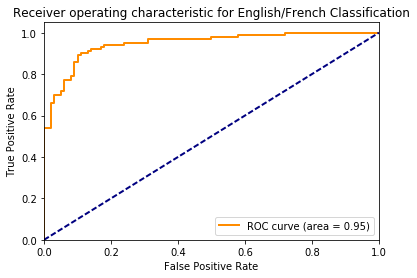

In [65]:
plot_roc_auc_curve(fpr, tpr, roc, 'English/French Classification')

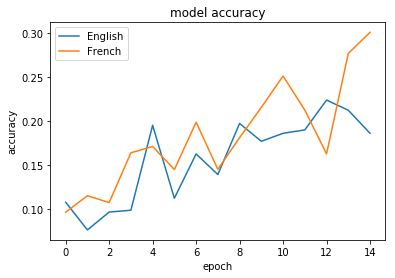

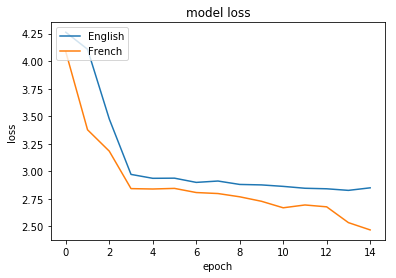

In [529]:
# summarize history for accuracy
plot_graphs = True;
if plot_graphs == True:
    plt.plot(history_english.history['acc'])
    #plt.plot(history_english.history['val_acc'])

    plt.plot(history_french.history['acc'])
    #plt.plot(history_french.history['val_acc'])

    #legend = ['eng_train', 'eng_test', 'frn_train', 'frn_test'];
    legend = ['English', 'French'];
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')
    #plt.savefig('accuracy_e_60___lr_0.001___b_64.png')

    plt.show()
    # summarize history for loss
    plt.plot(history_english.history['loss'])
    #plt.plot(history_english.history['val_loss'])

    plt.plot(history_french.history['loss'])
    #plt.plot(history_french.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(legend, loc='upper left')
    #plt.savefig('loss_e_60___lr_0.001___b_64.png')

    plt.show()

In [594]:
predict_results(2048,10)

0.63
0.63


'-Batch Size\t2048\t-Epochs\t10\t-ROC\t0.63\t-ACC\t0.63'

In [596]:
predict_results(2048,10)

0.654
0.654


'-Batch Size\t2048\t-Epochs\t10\t-ROC\t0.654\t-ACC\t0.654'

In [58]:
np.random.sample((10,10)).shape

(10, 10)